In [1]:
import numpy as np
import xarray as xr

In [2]:
import proplot as pplt

In [3]:
import matplotlib as mpl

In [4]:
import matplotlib.pyplot as plt

In [5]:
import cftime
from datetime import timedelta

In [6]:
import xesmf as xe

In [7]:
def regrid(ds_in):
    ds_out = xe.util.grid_2d(-100,50,1, 10, 50, 1) 
    # longitude range and resolution, latitude range and resolution
    
    regridder = xe.Regridder(ds_in, ds_out, 'bilinear',\
                             ignore_degenerate=True,periodic=True,unmapped_to_nan=True)
    res=[]
    for variable in ['tos_JAS_mean','tos_annual_mean']:
        var=ds_in[variable]
        da_reg=regridder(var)
        ds_reg=da_reg.to_dataset(name=variable)
        res.append(ds_reg)
    return xr.merge(res) 

In [8]:
scn_list=['ssp126','ssp245','ssp370','ssp585']

In [9]:
tseries_gulf={}
tseries_med={}
for scn in scn_list:
    print(scn)
    tseries_med[scn]=xr.open_dataset('./med_'+scn+'_correctens_anomfrom2016.nc')
    tseries_gulf[scn]=xr.open_dataset('./gulf_'+scn+'_correctens_anomfrom2016.nc')


ssp126
ssp245
ssp370
ssp585


In [10]:
ds_dict={}
for scn in scn_list:
    ds_dict[scn]=xr.open_dataset('./'+scn+'_correctens.nc',chunks='auto')

In [11]:
hadi_df=xr.open_dataset('/home/users/rahuls/ANDREW/COLLAB/TRUEMAN/HadISST_sst.nc')

In [12]:
hadi_df=hadi_df.rename(dict(latitude='lat',longitude='lon',sst='tos'))

In [13]:
hadI_2016_JAS=hadi_df.sel(time=slice('2016-07-01','2016-09-30')).mean(dim='time')
hadI_2016_annual=hadi_df.sel(time=slice('2016-01-01','2016-12-30')).mean(dim='time')

In [14]:
hadI_2016_JAS=hadI_2016_JAS.rename(dict(tos='tos_JAS_mean'))
hadI_2016_annual=hadI_2016_annual.rename(dict(tos='tos_annual_mean'))

In [15]:
hadI_2016=xr.merge([hadI_2016_JAS,hadI_2016_annual],compat='override')

In [16]:
hadI_2016=hadI_2016[['tos_JAS_mean','tos_annual_mean']]

In [17]:
hadI_2016_regrid=regrid(hadI_2016)


In [18]:
get_year=lambda x: x.year
get_year=np.vectorize(get_year)

In [19]:
def get_thresholdyear(da):
    diff=da-da.isel(time=0) 
    new_ds=diff+hadI_2016_regrid.tos_JAS_mean
    new_ds_masked=new_ds.where(new_ds<28)
    new_ds_masked=new_ds_masked.fillna(-999999)# filling with -ve values so that cumulative sum will decrease after thershold
    new_ds_int=new_ds_masked.cumsum(dim='time')
    new_ds_int.coords['time']=new_ds_masked.time
    idxmax=new_ds_int.idxmax(dim='time')
    years=xr.apply_ufunc(get_year,idxmax.compute())
    return years.to_dataset()

In [20]:
years_JAS={}
for scn in scn_list:
    ds_mean=ds_dict[scn].tos_JAS_mean
    ds_yrs=get_thresholdyear(ds_mean)
    years_JAS[scn]=ds_yrs.rename(dict(time='yr_mean'))


In [21]:
years_JAS['ssp126']

<xarray.Dataset>
Dimensions:  (y: 40, x: 150)
Coordinates:
    lat      (y, x) float64 10.5 10.5 10.5 10.5 10.5 ... 49.5 49.5 49.5 49.5
    lon      (y, x) float64 -99.5 -98.5 -97.5 -96.5 ... 46.5 47.5 48.5 49.5
Dimensions without coordinates: y, x
Data variables:
    yr_mean  (y, x) int64 2016 2016 2016 2016 2016 ... 2016 2016 2016 2016 2016

ssp126
ssp245
ssp370
ssp585


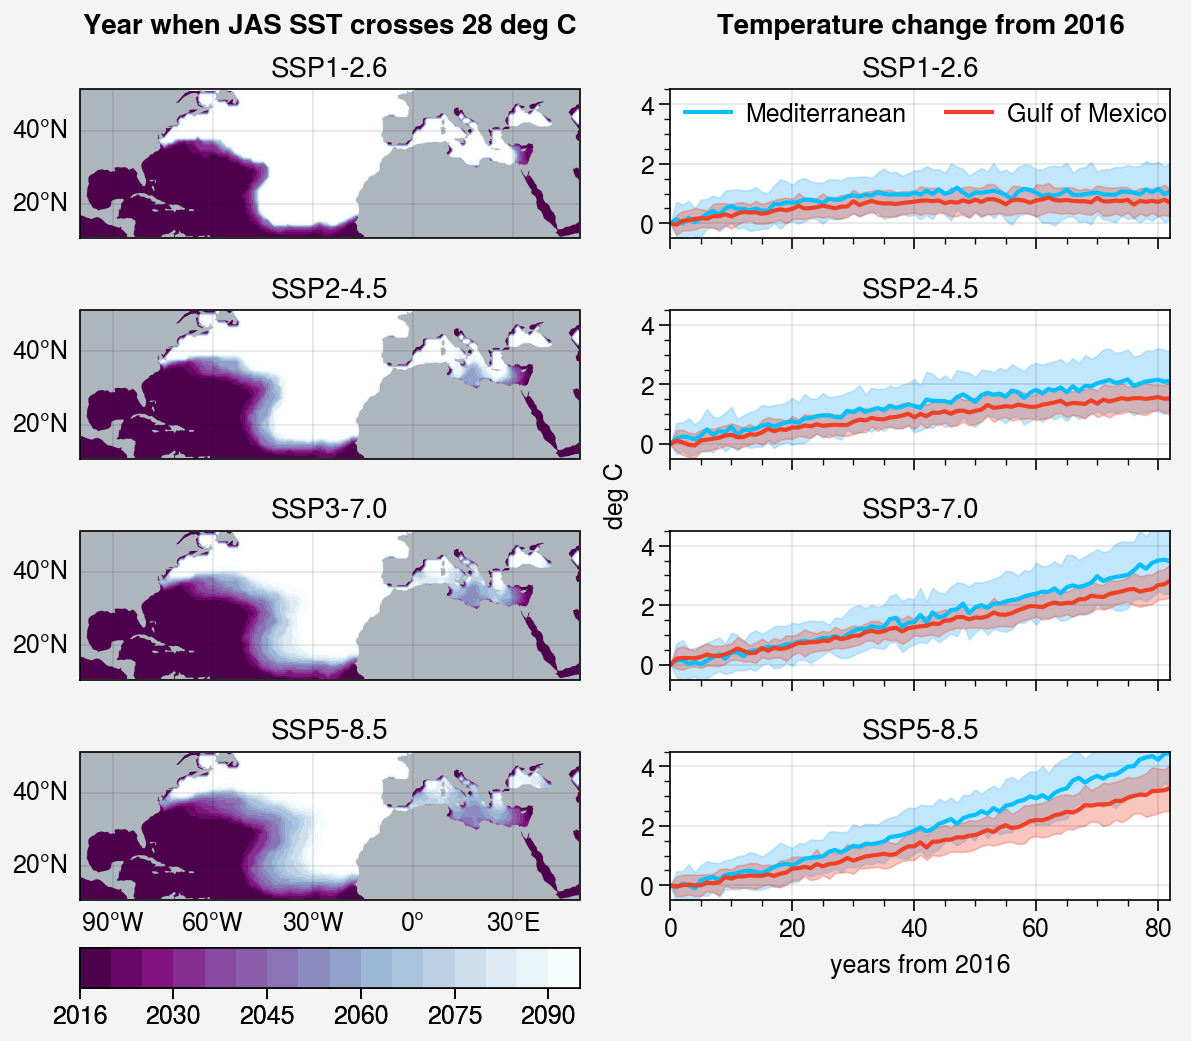

In [60]:
fig,axes=pplt.subplots(nrows=4,ncols=2,proj={(1,3,5,7):'mill'})

idx=0
lonlabels=[False,False,False,False,False,False,True,False]
levs=np.arange(2020,2100,5)
levs=np.insert(levs,0,2016)
cmap='BuPu_r'#pplt.Colormap('BuPu_r',gamma=1)
for scn in scn_list:
    print(scn)
    
    ax=axes[idx]
    ds=years_JAS[scn]
    # ds=xr.where(ds.yr_mean < 2100,ds,np.nan)
    lat=ds.lat.values
    lon=ds.lon.values
    val=ds.yr_mean.values
    map1=ax.contourf(lon,lat,val,cmap=cmap,levels=levs)
    title_string=scn.upper()[:-2]+'-'+scn[-2:-1]+'.'+scn[-1:]
    ax.format(land=True,landcolor='gray5',lonlim=(-100,50),latlim=(10,50),\
              latlines=20, lonlines=30,latlabels=True,lonlabels=lonlabels[idx],\
              title=title_string)
    if idx>4:
        ax.colorbar(map1,loc='b')
    
    idx=idx+1

    
    ax=axes[idx]
    med_ensmean=tseries_med[scn].tos_JAS_mean
    gulf_ensmean=tseries_gulf[scn].tos_JAS_mean
    
    val=med_ensmean.values
    stdmed=tseries_med[scn].tos_JAS_std
    stdmed_val=stdmed.values
    
    
    x=np.arange(len(val))
    line1=ax.plot(val,label='Mediterranean',c='deepskyblue')
    line1_sd=ax.area(x,val-stdmed_val,val+stdmed_val,c='lightskyblue',alpha=0.5)
    
    
    val2=gulf_ensmean.values
    stdgulf=tseries_gulf[scn].tos_JAS_std
    stdgulf_val=stdgulf.values
    
    line2=ax.plot(val2,label='Gulf of Mexico',c='tomato')
    line2_sd=ax.area(x,val2-stdgulf_val,val2+stdgulf_val,alpha=0.3,c='tomato')
    title_string=scn.upper()[:-2]+'-'+scn[-2:-1]+'.'+scn[-1:]
    ax.format(xlabel='years from 2016',ylabel='deg C',ylim=(-0.5,4.5),yticks=[0,2,4],title=title_string)
    if idx==1:
        ax.legend(loc='ul',ncols=2,frameon=False)
 

    idx=idx+1
fig.format(collabels=['Year when JAS SST crosses 28 deg C','Temperature change from 2016']) 
fig.save('./Number_of_years_JAS_from_ens_mean_squential_colorbar.png',dpi=600)